In [1]:
# Initial imports
import numpy as np
import pandas as pd
from pathlib import Path
import arch as arch

%matplotlib inline

In [2]:
#Other Imports 
from collections import Counter
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

ModuleNotFoundError: No module named 'keras'

In [ ]:
#LTSM Imports 
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
# Set the random seed for reproducibility
# Note: This is used for model prototyping, but it is good practice to comment this out and run multiple experiments to evaluate your model.
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

In [3]:
#Reading In CSV
file_path = Path('PrivateEquityReturnsFinal.csv')
pe_df = pd.read_csv(file_path, parse_dates=True, index_col='Date', infer_datetime_format=True)
pe_df

,Index,Quarter,Private Equity Returns,Cumulative,100,Unnamed: 6,Unnamed: 7
Date,,,,,,,
1986-06-30,1986 Q2,Q2,4.22,104.22,104.22,NaN,NaN
1986-09-30,1986 Q3,Q3,-2.60,101.62,101.62,NaN,NaN
1986-12-31,1986 Q4,Q4,1.11,102.73,102.73,NaN,NaN
1987-03-31,1987 Q1,Q1,3.73,106.46,106.46,NaN,NaN
1987-06-30,1987 Q2,Q2,1.28,107.74,107.74,NaN,NaN
...,...,...,...,...,...,...,...
2018-09-30,2018 Q3,Q3,3.84,532.50,532.50,NaN,NaN
2018-12-31,2018 Q4,Q4,-1.95,530.55,530.55,NaN,NaN
2019-03-31,2019 Q1,Q1,4.89,535.44,535.44,NaN,NaN


In [4]:
df = pd.DataFrame(pe_df['Private Equity Returns'])
df

,Private Equity Returns
Date,
1986-06-30,4.22
1986-09-30,-2.60
1986-12-31,1.11
1987-03-31,3.73
1987-06-30,1.28
...,...
2018-09-30,3.84
2018-12-31,-1.95
2019-03-31,4.89


In [5]:
df['Lagged_Return'] = df.shift(1)
df

,Private Equity Returns,Lagged_Return
Date,,
1986-06-30,4.22,NaN
1986-09-30,-2.60,4.22
1986-12-31,1.11,-2.60
1987-03-31,3.73,1.11
1987-06-30,1.28,3.73
...,...,...
2018-09-30,3.84,5.37
2018-12-31,-1.95,3.84
2019-03-31,4.89,-1.95


In [6]:
df=df.dropna()
df

,Private Equity Returns,Lagged_Return
Date,,
1986-09-30,-2.60,4.22
1986-12-31,1.11,-2.60
1987-03-31,3.73,1.11
1987-06-30,1.28,3.73
1987-09-30,1.79,1.28
...,...,...
2018-09-30,3.84,5.37
2018-12-31,-1.95,3.84
2019-03-31,4.89,-1.95


In [7]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [8]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Try a window size anywhere from 1 to 10 and see how the model performance changes
window_size = 1

# Column index 1 is the `Close` column
feature_column = 1
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

In [9]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[: split - 1]
X_test = X[split:]
y_train = y[: split - 1]
y_test = y[split:]

In [10]:
# Use MinMaxScaler to scale the data between 0 and 1. 
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [11]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.5997037 ]]

 [[0.39762963]]

 [[0.50755556]]

 [[0.58518519]]

 [[0.51259259]]] 

X_test sample values:
[[[0.37718519]]

 [[0.60888889]]

 [[0.64681481]]

 [[0.65333333]]

 [[0.60562963]]]


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [13]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
model = Sequential()

number_units = 50
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
#model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
#model.add(Dropout(dropout_fraction))
# Layer 3
#model.add(LSTM(units=number_units))
#model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(25))
model.add(Dense(1))

In [14]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [15]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 50)             10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 50)             20200     
_________________________________________________________________
dense (Dense)                (None, 1, 25)             1275      
_________________________________________________________________
dense_1 (Dense)              (None, 1, 1)              26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs=10, shuffle=True, batch_size=10, verbose=1)

Train on 90 samples
Epoch 1/10
90/90 [==============================] - 2s 21ms/sample - loss: 0.3060
Epoch 2/10
90/90 [==============================] - 0s 317us/sample - loss: 0.2109
Epoch 3/10
90/90 [==============================] - 0s 295us/sample - loss: 0.1139
Epoch 4/10
90/90 [==============================] - 0s 344us/sample - loss: 0.0406
Epoch 5/10
90/90 [==============================] - 0s 294us/sample - loss: 0.0253
Epoch 6/10
90/90 [==============================] - 0s 291us/sample - loss: 0.0236
Epoch 7/10
90/90 [==============================] - 0s 294us/sample - loss: 0.0197
Epoch 8/10
90/90 [==============================] - 0s 274us/sample - loss: 0.0210
Epoch 9/10
90/90 [==============================] - 0s 301us/sample - loss: 0.0203
Epoch 10/10
90/90 [==============================] - 0s 486us/sample - loss: 0.0201


In [17]:
# Evaluate the model
model.evaluate(X_test, y_test)

40/40 [==============================] - 1s 13ms/sample - loss: 0.0059


0.0059211340732872484

In [18]:
# Make some predictions
predicted = model.predict(X_test)

In [19]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

ValueError: Found array with dim 3. Estimator expected <= 2.

In [20]:
# Create a DataFrame of Real and Predicted values
private_equity = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
})
private_equity.head()

NameError: name 'real_prices' is not defined

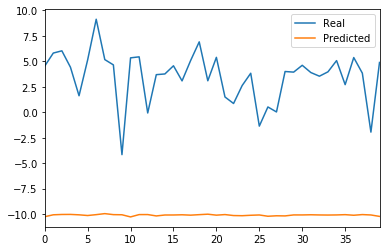

In [239]:
# Plot the real vs predicted values as a line chart
private_equity.plot()

In [ ]:
scaled_returns

In [ ]:
pe_test = pe_df.dropna()


In [ ]:
pe_df['pe_returns'] = pe_df['Private Equity Returns']

In [ ]:
pd.DataFrame(scaled_returns).hist()

In [ ]:
pe_df.pe_returns.hist()

In [ ]:
#pe_df = pe_df.dropna()
#pe_df

In [ ]:
#pe_2_df = pe_df.set_index(['Date'])
#pe_2_df

In [ ]:
#pe_final = pe_df['Private Equity Returns'].copy()
#pe_final#

In [ ]:
#pe_final = pd.DataFrame(columns=['Date','Private Equity Returns'])
#pe_final

In [ ]:
#pe_final = pe_final.drop([134])
#pe_final

In [ ]:
#pe_final = pe_final.set_index('Date')
#pe_final

In [ ]:
pe_df['Private Equity Returns'].plot()

In [ ]:
pe_df['Cumulative'].plot()

In [ ]:
pe_df = df.asfreq('Q-DEC')

In [ ]:
pd.infer_freq(pe_df.index)

In [ ]:
from arch import arch_model

In [ ]:
# 'p' and 'q'  are akin to the 'p' and 'q' of an ARMA model.
# 'vol="GARCH"' means that we're using a GARCH model.
# The 'mean="Zero"' means that we're estimating a GARCH.
model = arch_model(pe_df.pe_returns, mean="Zero", vol="Garch", p=3, q=3)

In [ ]:
# Fit the GARCH Model
res = model.fit()

In [ ]:
import statsmodels.api as sm

In [ ]:
ts_noise, ts_trend = sm.tsa.filters.hpfilter(pe_df.pe_returns)

In [ ]:
ts_noise.plot()

In [ ]:
ts_trend.plot()

In [ ]:
fit.

In [ ]:
pe_df.pe_returns.plot()

In [ ]:
# Summarize the model results
res.summary()

In [ ]:
# Plot the model estimate of annualized volatility
fig = res.plot()

In [ ]:
# Construct Volatility Forecasts for the next 3 days
forecast_horizon = 3
# Take the last day of the data we used above. 
# If forecast horizon is 3, then the resulting 'h.1', 'h.2', and 'h.3' 
# are the forecasts for the following 3 days.
forecasts = res.forecast(start='2019-06-30', horizon=forecast_horizon)
forecasts.mean

In [ ]:
pe_df.tail()

In [ ]:
pe_df.tail()

In [ ]:
forecasts = res.forecast(start='2019-12-01', horizon=3)

In [ ]:
forecasts.variance

In [ ]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 12)
intermediate

In [ ]:
# The name of the column here is the date of the forecast.
# Each row represents the forecast of volatility for the following days.
# Transposing makes the forecast easier to plot
final = intermediate.dropna().T
final

In [ ]:
final.plot()

In [ ]:
import numpy as np
import pandas as pd
import hvplot.pandas

In [ ]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [ ]:
df.head()

In [ ]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [ ]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Try a window size anywhere from 1 to 10 and see how the model performance changes
window_size = 1

# Column index 1 is the `Close` column
feature_column = 1
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

In [ ]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[: split - 1]
X_test = X[split:]
y_train = y[: split - 1]
y_test = y[split:]